# I. Data Validation.

## 1. Validate the data

#### Import the file and the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import iqr

In [2]:
df = pd.read_csv('recipe.csv', na_values='NaN')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
# missing data and several columns are in the wrong data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


##### - missing  data in the ['recipe', 'calories', 'carbohydrate', 'protein'] columns seems to have a relationship.
##### - the missing data is more than 5% of the data so i can't just drop it.
##### - lot of missing data is present in high_traffic column

<AxesSubplot:>

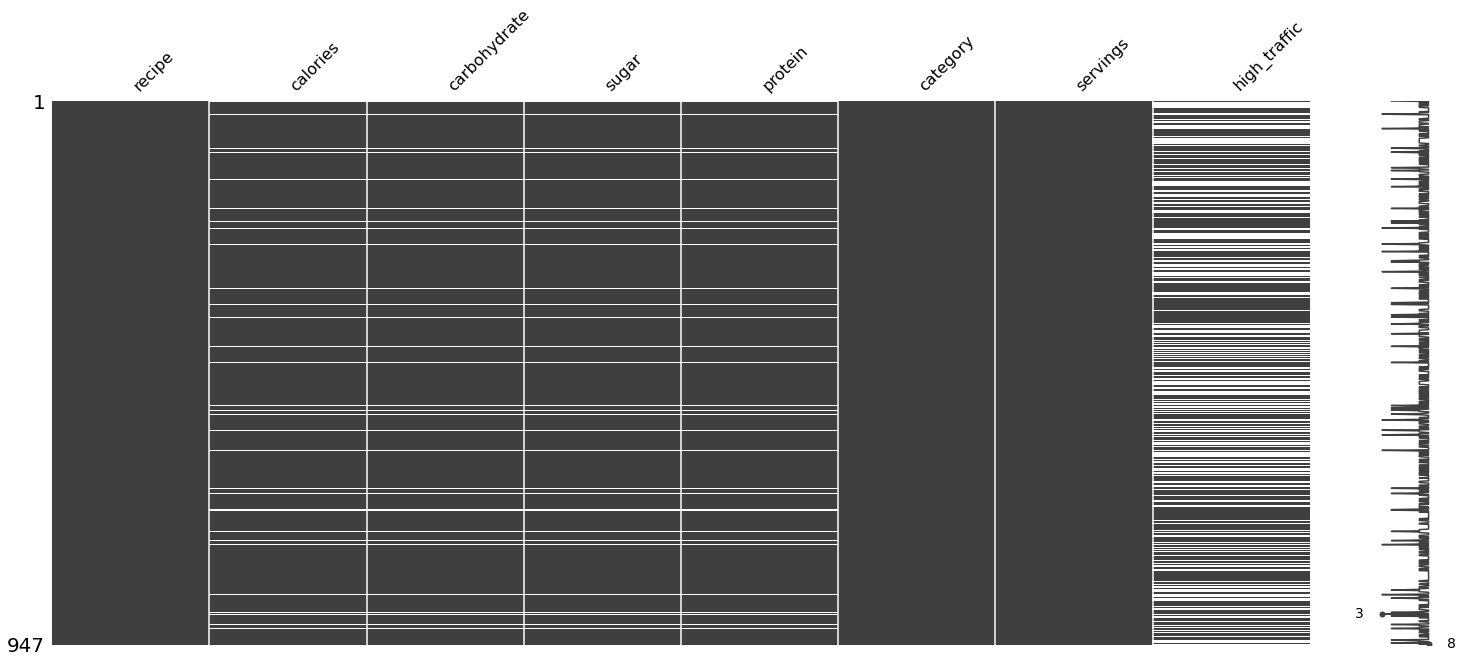

In [4]:
msno.matrix(df)

##### Huge difference between the data values in the 75% and the Max, which suggests the presence of outliers in the dataset.

In [5]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


##### Inconsistent format in the serving column and the column is in the wrong data type.

In [6]:
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

##### 11 instead of 10 unique categories. the extra category is 'Chicken Breast'

In [7]:
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

## 2. Data Cleaning

###### missing values in this column mean the recipe wasn't recieving high traffic. so i'm going to replace nan with 'Low'

In [8]:
df["high_traffic"].unique()

array(['High', nan], dtype=object)

In [20]:
df['high_traffic'] = df['high_traffic'].fillna('Low')
df['high_traffic'].value_counts(normalize=True)

High    0.606125
Low     0.393875
Name: high_traffic, dtype: float64

##### category column should contain 10 unique categories, in our case we have 11. So i'm going to replace 'chicken breast' with 'chicken' to add those values to the appropriate category.

In [10]:
df["category"].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [11]:
df["category"] = df["category"].str.replace('Chicken Breast', 'Chicken')
df["category"].nunique()

10

##### serving column contains inconsistent format and is an object data type instead of integer. so i will normalize the format in the column to only contain numeric values, then change the data type to integer.

In [12]:
df["servings"].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [13]:
df["servings"] = df["servings"].str.replace('4 as a snack', '4') \
                               .str.replace('6 as a snack', '6')

In [14]:
df["servings"].unique()

array(['6', '4', '1', '2'], dtype=object)

In [15]:
df["servings"] = df["servings"].astype('int')
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int64
high_traffic     object
dtype: object

###### Dealing with outliers in ["carbohydrate", "calories", "sugar", "protein"] columns
*Outliers refers to an observation that lies an abnormal distance from other values in a random sample.
These outliers will negatively impact our analysis and reduce the accuracy of the predictive model we are trying to create.*
- The data seems to vary greatly in these columns, which suggests the presences of outliers. **Check Table A and Graph 0 below**.

In [16]:
# Table A
df[["carbohydrate", "calories", "sugar", "protein"]].describe()

,carbohydrate,calories,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,35.069676,435.939196,9.046547,24.149296
std,43.949032,453.020997,14.679176,36.369739
min,0.030000,0.140000,0.010000,0.000000
25%,8.375000,110.430000,1.690000,3.195000
50%,21.480000,288.550000,4.550000,10.800000
75%,44.965000,597.650000,9.800000,30.200000
max,530.420000,3633.160000,148.750000,363.360000


<AxesSubplot:>

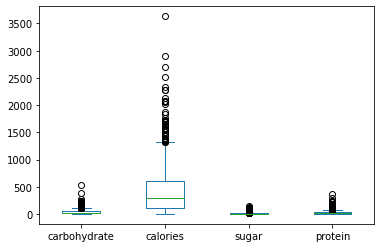

In [17]:
# Graph 0
numeric_cols =  ["carbohydrate", "calories", "sugar", "protein"]
df[numeric_cols].plot(kind='box')

##### Removing outliers

**There are mutiple ways to doing this, but i chose to stick to a very simple and straightforward approach and try to make it more convenient by incorporating this approach into a python function**

*The function remove_outliers_updated() takes in two arguements, a dataframe and a list of numeric columns suspected of containing outliers. The function returns a dataframe where the outliers are converted into nan values.*
*The reason why i chose to do this instead of dropping the outliers, is because the dataset is already small and getting rid of more data with lead to information loss.*



In [18]:
def remove_outliers_updated(df, cols):
    # Copy the original DataFrame to avoid modifying it
    df_copy = df.copy()
    
    # Loop through each column and replace outliers with NaN values
    for col in cols:
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_copy.loc[(df_copy[col] < lower_bound) | (df_copy[col] > upper_bound), col] = np.nan
    
    # Return the DataFrame with outliers replaced by NaN values
    return df_copy

In [19]:
new_df = remove_outliers_updated(df, ["carbohydrate", "calories", "sugar", "protein"])
new_df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,848.000000,837.000000,816.000000,818.000000,947.000000
mean,474.000000,362.641663,26.318244,5.370061,15.362531,3.477297
std,273.519652,319.311624,23.348508,4.878443,16.467054,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,102.230000,7.790000,1.580000,2.647500,2.000000
50%,474.000000,266.060000,19.250000,3.925000,9.150000,4.000000
75%,710.500000,542.507500,38.660000,7.840000,23.117500,4.000000
max,947.000000,1321.780000,99.820000,20.990000,70.690000,6.000000


##### Note: *outliers have been turned into NaNs and the data seems less varied and more consistent.*

# II. Data Visualization
#### 1. Two different types of graphic showing single variables only

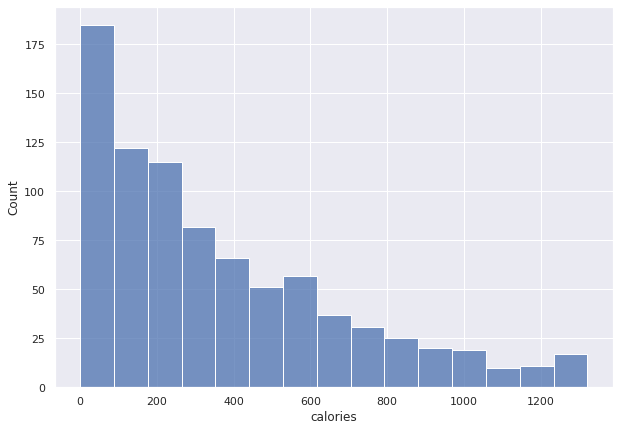

In [20]:
# Graph 1.
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(figsize=(10,7))

#create boxplot in each subplot
sns.histplot(x=new_df["calories"])

plt.show()

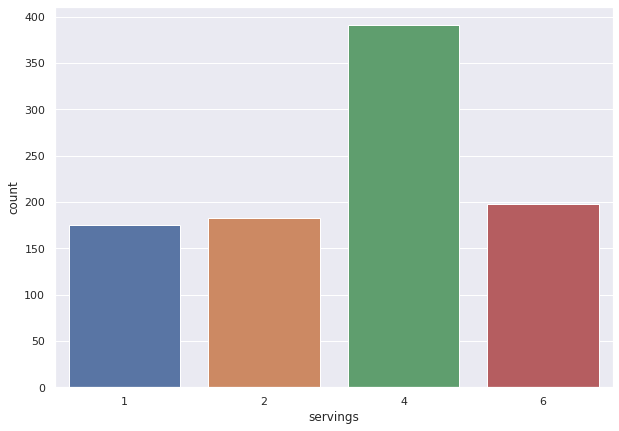

In [21]:
# Graph 2
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(figsize=(10,7))

#create boxplot in each subplot
sns.countplot(x=new_df["servings"])

plt.show()

#### 2. At least one graphic showing two or more variables

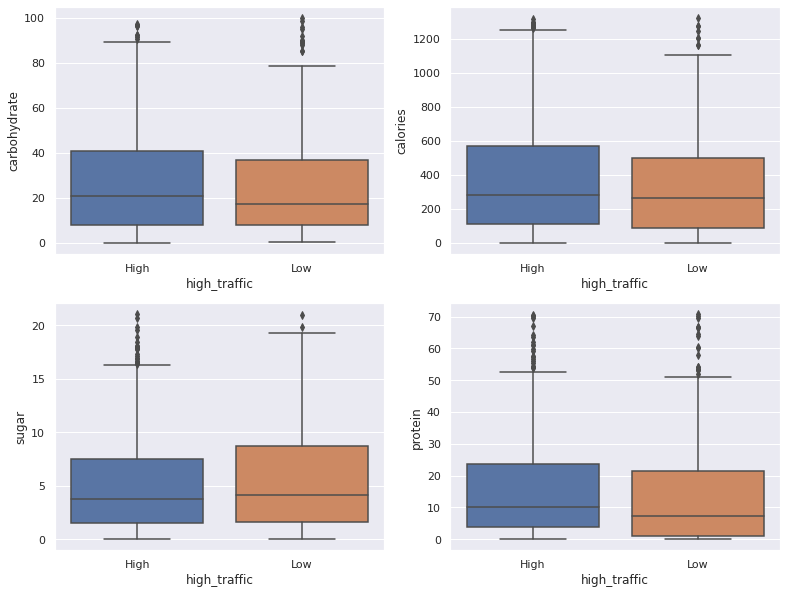

In [22]:
# Graph 3
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(13,10))

#create boxplot in each subplot
sns.boxplot(y=new_df["carbohydrate"], x=new_df["high_traffic"], ax=axes[0,0])
sns.boxplot(y=new_df["calories"], x=new_df["high_traffic"], ax=axes[0,1])
sns.boxplot(y=new_df["sugar"], x=new_df["high_traffic"], ax=axes[1,0])
sns.boxplot(y=new_df["protein"], x=new_df["high_traffic"], ax=axes[1,1])
plt.show()

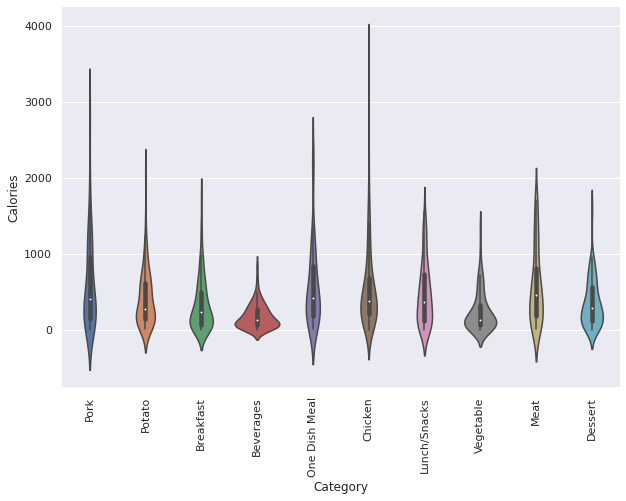

In [23]:
# Graph 4:
fig, axes = plt.subplots(figsize=(10,7))
sns.violinplot(x='category', y='calories', data=df,whis=10)
#,whis=10
# Plot the y-axis on a log scale
#plt.yscale('log')
 
# Remove unneeded lines and label axes
sns.despine(left=True, bottom=True)
plt.xlabel('Category')
plt.ylabel('Calories')
plt.xticks(rotation=90)
plt.show()

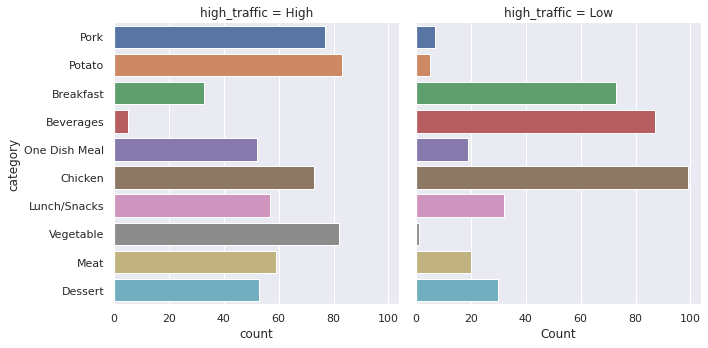

In [24]:
# Graph 5
sns.catplot(y="category", data=df, kind="count", col="high_traffic")
plt.xlabel('Count')
plt.show()

#### 3. Description of your findings




---


##### Graph 1: The histogram of the Calories dataset is righ-sweked, since the majority of the data points have low values. which would make sense considering that "Tasty Bytes" main goal to provide users with healthy and balanced recipes.


---


##### Graph  2: The most common number of servings for recipe is 4, which accounts for 391 recipes or 41% of the recipes in the dataset.



---

##### Graph 3: From this graph we conclude that recipes which contain higher amounts of protein, carbohydrate and calories tend to get slightly more "high traffic". This however isn't true for sugar.



---

##### Graph 4: From this graph it is clear the recipes that include meat or chicken tend to have higher calories, whereas recipes that contain beverages and vegetables tend to have lower calories.


---

##### Graph 5: Recipes with heigher calories, carbohydrate and protein get higher traffic.

# Model Development:
#### 1. What type of problem this is? (regression, classification or clustering)
- The problem presented here is a binary Classification problem.

#### 2. Machine Learning Preprocessing.

In [25]:
# import necessary packages and files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

##### encode the "high_traffic" column so it holds numeric values using pandas. This is because the sci-kit learn only accepets numeric values and to use the column as the target variable.

In [26]:
df["high_traffic"] = df["high_traffic"].apply(lambda val: 1 if val == 'High' else 0)
df["high_traffic"].value_counts()

1    574
0    373
Name: high_traffic, dtype: int64

##### Created a dataframe containing only numeric columns with NaN values.

In [27]:
df_num = df.drop(['high_traffic', 'category', 'servings'], axis=1)

##### Impute the numeric dataframe using the mean value of each column.

In [28]:
imp = SimpleImputer(strategy='mean')
df_imp = pd.DataFrame(imp.fit_transform(df_num), columns=df_num.columns)
df_imp.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
dtype: int64

##### The reason is chose to Normalize the data instead of Standardizing the dataframe, is because the data isn't Gaussian distributed and i already got rid of outliers that are known to negatively impact the normalizer performance. Also after multiple trails and errors this is the approach that led to the best results.

In [29]:
# normalize the data in the imputed numeric data frame
normalize = Normalizer()
df_normalized = pd.DataFrame(normalize.fit_transform(df_imp), columns=df_num.columns)
df_normalized.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,0.690320,0.557289,0.068110,0.019914,0.045188
std,0.291195,0.319798,0.101974,0.044516,0.081124
min,0.002283,0.000569,0.000029,0.000011,0.000000
25%,0.489255,0.269011,0.013331,0.002625,0.005696
50%,0.781974,0.590108,0.036453,0.007223,0.019396
75%,0.949281,0.854629,0.074853,0.017801,0.045427
max,0.999940,0.999834,0.854630,0.723891,0.788458


##### Encode the category column using pandas so we can feed this data into sci-kit learn and improve model performance.

In [30]:
df_enc = pd.get_dummies(df["category"], drop_first=True)

##### Concatenate both dataframes and high traffic column on axis 1 and save to df_new.

In [31]:
df_new = pd.concat([df_normalized, df_enc, df['high_traffic']], axis=1)
df_new.head()

,recipe,calories,carbohydrate,sugar,protein,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable,high_traffic
0,0.002283,0.995049,0.080048,0.020649,0.055122,0,0,0,0,0,0,1,0,0,1
1,0.038132,0.676456,0.735179,0.012583,0.017541,0,0,0,0,0,0,0,1,0,1
2,0.003278,0.998896,0.046630,0.003376,0.003147,1,0,0,0,0,0,0,0,0,0
3,0.036734,0.891084,0.280650,0.354762,0.000184,0,0,0,0,0,0,0,0,0,1
4,0.181244,0.980532,0.067060,0.028999,0.019212,0,0,0,0,0,0,0,0,0,0


##### X contains the features and y the target veriable

In [32]:
X = df_new.drop('high_traffic', axis=1).values
y = df_new["high_traffic"].values
print(X.shape, y.shape)

(947, 14) (947,)


##### Splitting the data into train and test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## Fitting a baseline model: KNearestNeighborsClassifier

In [34]:
np.random.seed(2)
steps = [('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {'knn__n_neighbors':np.arange(1,50),
              'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__leaf_size':np.arange(1, 70)}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv = RandomizedSearchCV(pipeline, parameters, cv=kf, scoring='accuracy',error_score='raise', return_train_score=False,verbose=1, random_state=2)
cv.fit(X_train, y_train)
y_pred_knn = cv.predict(X_test)
print(cv.best_params_, cv.best_score_)
#print(cv.score(X_test, y_test))
test_accuracy = accuracy_score(y_test, y_pred_knn) * 100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'knn__n_neighbors': 42, 'knn__leaf_size': 9, 'knn__algorithm': 'auto'} 0.7437260369466713
Accuracy for our testing dataset with tuning is : 79.47%


# Fitting a comparison model: DecisionTreeClassifier

In [35]:
np.random.seed(3)
steps = [('tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)
params = {'tree__max_depth': np.arange(1, 50),
          'tree__criterion': ['entropy', 'gini'],
          'tree__splitter': ['best', 'random'],
          'tree__min_samples_split': np.linspace(0.001, 1, 100)}
kf = KFold(n_splits=5, shuffle=True, random_state=3)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)
cv = RandomizedSearchCV(pipeline, params, cv=kf, scoring='accuracy', return_train_score=False, error_score='raise', verbose=1, random_state=1)
cv.fit(X_train, y_train)
y_pred_tree = cv.predict(X_test)
print(cv.best_params_, cv.best_score_)
print(cv.score(X_test, y_test))
tree_test_accuracy = accuracy_score(y_test, y_pred_tree) * 100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(tree_test_accuracy) )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'tree__splitter': 'random', 'tree__min_samples_split': 0.445, 'tree__max_depth': 38, 'tree__criterion': 'gini'} 0.7516207737887765
0.8052631578947368
Accuracy for our testing dataset with tuning is : 80.53%


## Model evaluation using model's accuracy score.
#### KNN classifier got  an accuracy score of 79%.

In [36]:
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[54 21]
 [18 97]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73        75
           1       0.82      0.84      0.83       115

    accuracy                           0.79       190
   macro avg       0.79      0.78      0.78       190
weighted avg       0.79      0.79      0.79       190



#### DecisionTreeClassifier got an accuracy score of 81%.

In [37]:
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[58 17]
 [20 95]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        75
           1       0.85      0.83      0.84       115

    accuracy                           0.81       190
   macro avg       0.80      0.80      0.80       190
weighted avg       0.81      0.81      0.81       190



#### Conclusion: DecisionTreeClassifier is the better model since it has higher accuracy, precision, recall and f1 scores and therefore more likely to correctly predict the recipes to gain high traffic and thereby answering the business question.

## Definition of a metric for the business to monitor
#### 1. How should the business monitor what they want to achieve?
- To monitor what they want to achieve, the business should define clear and measurable goals, such as increasing website traffic or subscription rates. They should also establish key performance indicators (KPIs) that align with these goals, such as the number of page views or the conversion rate from website visitors to subscribers. Regularly tracking these metrics will help the business understand how well they are achieving their objectives and whether any adjustments to their strategies are necessary.

#### 2. Estimate the initial value(s) for the metric based on the current data?
-  To estimate the initial value of the metric based on the current data, I would first determine the number of times the selected favorite recipe was shown on the website. Let's say the favorite recipe was shown 100 times. Then, I would count how many of those times the website traffic increased by 40% or more after the recipe was displayed. Let's say this happened 40 times out of the 100 times the recipe was shown. The initial value of the metric would then be the proportion of times that the selected favorite recipe led to increased traffic, which is calculated by dividing the number of times the recipe led to increased traffic (40) by the total number of times the recipe was shown (100). In this case, the initial value of the metric would be 0.4 or 40%.
(since i don't have the historical data i can't answer this question effectively).

## Final summary including recommendations that the business should undertake

##### As part of this project involving data from Tasty Bytes, an exploratory data analysis was conducted which included visuals. The analysis revealed that recipes with higher amounts of calories, carbs, and protein tend to get higher traffic than other recipes posted on the homepage of the Tasty Bytes website.
eventhough categories with the highest rate of 'high' traffic tend to have low number of recipes.

To predict whether a recipe will get high or low traffic, two classification models were fitted: a k-nearest neighbors model and a decision tree classifier. The decision tree classifier achieved a higher accuracy than the k-nearest neighbors model, indicating that it may be a better fit for predicting recipe traffic despite there being less of recipes within said categories

Based on these findings, there are three recommendations that the Tasty Bytes marketing team could implement to increase recipe traffic on their website:

- Reduce the number of recipes in certain categories: The number of recipes in categories with low traffic needs to be reduced, while the number of recipes in categories with high traffic needs to be increased in order to increase customer engagement.

- Highlight high-calorie, high-carb, and high-protein recipes: Based on the exploratory data analysis, recipes with these characteristics tend to generate higher traffic. The Tasty Bytes marketing team could feature these recipes more prominently on their website or social media platforms to attract more traffic.

- Use the decision tree classifier for predicting recipe traffic: The decision tree classifier achieved a higher accuracy in predicting recipe traffic than the k-nearest neighbors model. The Tasty Bytes team could use this model to identify recipes that are likely to generate high traffic, and use this information to prioritize which recipes to feature on their website or social media platforms.

By implementing these recommendations, Tasty Bytes can increase traffic to their website and ensure that their recipes are being seen by the right audience.